# Transfer learning week. 
## pytorch 

In [1]:
import math, seaborn as sns, numpy as np, pandas as pd, os, sys, posixpath, pathlib 
from matplotlib import pyplot as plt

import pprint 
# @typedispatch
# @delegate
# class DataLoader(Generic[T_co])
# T_co = TypeVar('T_co', covariant=True)
# T = TypeVar('T')
# _worker_init_fn_t = Callable[[int], None]


In [3]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# https://download.pytorch.org/tutorial/hymenoptera_data.zip
# !wget 'https://download.pytorch.org/tutorial/hymenoptera_data.zip' -o ./hymenoptera_data.zip
# https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/
# https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/
# https://pytorch.org/vision/stable/models.html


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from PIL import Image
from tempfile import TemporaryDirectory
from torchvision import models
print(dir(models)[0:5])

def show_dir( obj ): return [item for item in dir( obj ) if not item.startswith('_') ]

data_path = "./data/hymenoptera_data"
os.listdir( os.path.join( data_path,'train','bees') )[0:5]


/home/vscode/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['AlexNet', 'AlexNet_Weights', 'ConvNeXt', 'ConvNeXt_Base_Weights', 'ConvNeXt_Large_Weights']


['473618094_8ffdcab215.jpg',
 '174142798_e5ad6d76e0.jpg',
 '873076652_eb098dab2d.jpg',
 '2822388965_f6dca2a275.jpg',
 '92663402_37f379e57a.jpg']

In [4]:
torch.__version__ 

'1.13.1+cu117'

In [5]:
data_dir = 'data/hymenoptera_data'

#weights = models.ResNet18_Weights.DEFAULT
#preprocess = weights.transforms()
#preprocess

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
 
# each is a dataset (train and val), is a class that abstracts an iterable used during training. 
# dataloaders call the __get__item__ method of the dataset, which returns one example and its label 
# a dataset needs to implement as a minimum the __get_item__ and __geT_length__ methods 
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x) ,data_transforms[x]) for x in ['train', 'val']}
# inherits from 
# torchvision.datasets.folder.ImageFolder,
# torchvision.datasets.folder.DatasetFolder,
# torchvision.datasets.vision.VisionDataset,
# torch.utils.data.dataset.Dataset,

# some attyributes of this type of datasets 
print('attributes of a dataset ')
train_dataset =  image_datasets['train']
print( train_dataset.classes )
print( train_dataset.class_to_idx )
print( train_dataset.samples[180:190] )
print( train_dataset.targets[180:190] )


# a data loader iterates over a dataset and retieves batches. 
# each loader has a reference to its dataset
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, 
                                               shuffle=False, num_workers=1) for x in ['train', 'val']}
# same id 
# id(data_loaders['train'].dataset), id( image_datasets['train'])

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

#note that the class names are taken from the folder names. 
class_names = image_datasets['train'].classes
print( class_names, dataset_sizes )

attributes of a dataset 
['ants', 'bees']
{'ants': 0, 'bees': 1}
[('data/hymenoptera_data/train/bees/2651621464_a2fa8722eb.jpg', 1), ('data/hymenoptera_data/train/bees/2652877533_a564830cbf.jpg', 1), ('data/hymenoptera_data/train/bees/266644509_d30bb16a1b.jpg', 1), ('data/hymenoptera_data/train/bees/2683605182_9d2a0c66cf.jpg', 1), ('data/hymenoptera_data/train/bees/2704348794_eb5d5178c2.jpg', 1), ('data/hymenoptera_data/train/bees/2707440199_cd170bd512.jpg', 1), ('data/hymenoptera_data/train/bees/2710368626_cb42882dc8.jpg', 1), ('data/hymenoptera_data/train/bees/2722592222_258d473e17.jpg', 1), ('data/hymenoptera_data/train/bees/2728759455_ce9bb8cd7a.jpg', 1), ('data/hymenoptera_data/train/bees/2756397428_1d82a08807.jpg', 1)]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
['ants', 'bees'] {'train': 244, 'val': 153}


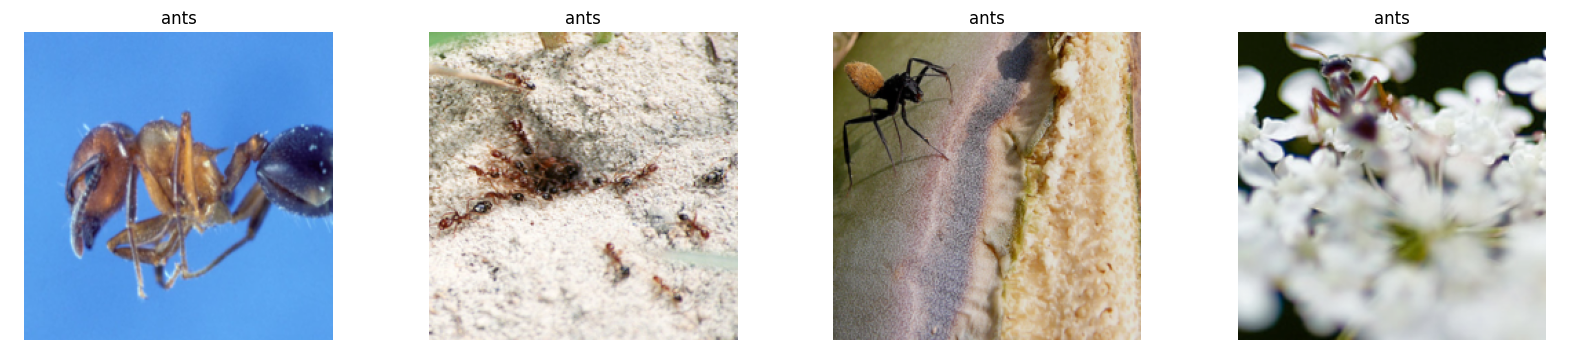

In [54]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


def display_image_tensors( inputs, labels = None,figsize= (20, 4) ):

    nrows, ncols = 1, inputs.shape[0]     
                       #ncols * x = 20 
    fig,ax = plt.subplots( figsize= figsize )
    plt.axis('off') 
    
    for image_index in range(ncols):  
        image = inputs[image_index]
        inp = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        fig.add_subplot(nrows, ncols, image_index + 1) 
        plt.imshow(inp)
        plt.axis('off') 
        if labels is not None: plt.title(labels[image_index]) 


idx_to_label = { idx:label for label,idx in data_loaders['train'].dataset.class_to_idx.items() } 
inputs, classes = next(iter(data_loaders['train']))
labels = [ idx_to_label[x] for x  in classes.tolist() ]
display_image_tensors( inputs, labels  )




In [55]:

#!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
# ther labels for imagenet1K 
with open('imagenet_classes.txt') as f: 
  classes = [line.strip() for line in f.readlines()]

# model with pre-trained weights and all the layers. 
# Note the last layer is the classification layer. Thats the one to fine-tune in the 
# general case.  
from torchvision.models import resnet18, ResNet18_Weights
model_ft = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)#'IMAGENET1K_V1')
pprint.pprint(model_ft)

def freeze_model( model ):
  model.eval() 
  for param in model.parameters(): 
      param.requires_grad = False

freeze_model( model_ft )

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

class  ant prob  98.29681396484375


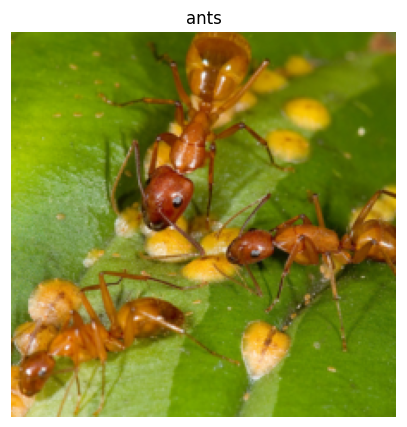

In [56]:
#get one image from  the new training set 
image1, label1 = image_datasets['val'][11] 
batch = torch.unsqueeze(image1, 0)
display_image_tensors( batch, labels= ['ants'], figsize= (5,5) )

model_ft.eval() 
out = model_ft(batch)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
_, max_prob_index = torch.max( out, 1 ) # 1 if for dim out is (images, labels )
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
print('class ', classes[max_prob_index[0]], 'prob ', percentage[max_prob_index[0]].item())


In [57]:
# lets see first whats the baseline. Whats the accuracy for the validation set. 
class IndexedDataset:
    def __init__(self, dataset): self.dataset = dataset 


    def __getitem__( self, idx ):
    
        sample, label  = self.dataset.__getitem__( idx )
        return sample,label, idx 

    def __getattr__(self, item):
        #print( 'Not found __getattr__ ', item)
        return self.dataset.__getattribute__(item)


    def __len__( self ):
        return len( self.dataset )
        

# baseline_dataset = image_datasets['val']
baseline_dataset =  IndexedDataset( image_datasets['val'] ) 
baseline_data_loader = torch.utils.data.DataLoader(baseline_dataset,batch_size=4, shuffle=True, num_workers=1)


probabilities = [] 
predictions = [] 
true_labels = [] 
indices = [] 
model_ft.eval() 
for b,c, sample_index in baseline_data_loader:
    
    out = model_ft( b )
    probs = torch.nn.functional.softmax( out, dim = 1 ).max( dim = 1 ).values.detach().numpy().tolist()
    probabilities = probabilities + probs  
    indices = indices + sample_index.detach().numpy().tolist()
    
    _, imagenet_indices = torch.max( out, 1 )
    imagenet_labels = [  classes[index] for index in imagenet_indices ] 
    predictions = predictions + imagenet_labels 
    true_labels = true_labels + ['ant' if x ==0 else 'bee' for x  in c.detach().numpy().tolist() ]
  



In [58]:
import pandas as pd 
df = pd.DataFrame( {'image_index':indices, 'probability': probabilities,  'prediction':predictions, 'label':true_labels} )
df['error'] = (df['prediction'] != df['label']).astype(int)
display( df.sample(10) )

,image_index,probability,prediction,label,error
142,45,0.819684,ant,ant,0
138,130,0.867886,bee,bee,0
139,63,0.869586,ant,ant,0
119,58,0.912483,ant,ant,0
130,100,0.991755,bee,bee,0
55,37,0.986696,ant,ant,0
135,26,0.544184,nail,ant,1
58,91,0.976633,bee,bee,0
132,151,0.995613,bee,bee,0
140,29,0.478978,ladybug,ant,1


In [59]:

def stats_for_labels( df, label_column='label', prediction_column = 'prediction' ):

    def _stats_for_label( df, label ):
        bees_df = df[ df['label'] == label ]
        num_bees, error_count, bees_true_count =  bees_df.shape[0], bees_df['error'].sum(), bees_df.shape[0] - bees_df['error'].sum()
        print(f'out of {num_bees} samples of {label}, miss-clasification occured a total of {error_count} times and {bees_true_count} where correctly classified') 
        return num_bees, error_count, bees_true_count

    _df = pd.DataFrame( {}, columns = ['label','total','error', 'correct', 'acc'] )
    for label in df[label_column].unique():
        _total, _error, _correct  = _stats_for_label( df, label )
        _df.loc[len(_df.index)] = [label, _total, _error, _correct, _correct/_total] 


   
    return _df.set_index('label') 

errors_df = df[ df['error'] == 1 ].sort_values(by ='probability',ascending=False).head(10)
display( errors_df )
stats = stats_for_labels( df ) 
display( stats  ) 



,image_index,probability,prediction,label,error
36,75,0.990557,rapeseed,bee,1
98,106,0.987223,daisy,bee,1
46,144,0.838418,rhinoceros beetle,bee,1
13,92,0.777499,monarch,bee,1
127,6,0.758185,bee,ant,1
15,2,0.752106,mantis,ant,1
71,103,0.628026,cicada,bee,1
111,149,0.568839,monarch,bee,1
9,112,0.565038,cardoon,bee,1
11,114,0.546736,apiary,bee,1


out of 83 samples of bee, miss-clasification occured a total of 18 times and 65 where correctly classified
out of 70 samples of ant, miss-clasification occured a total of 21 times and 49 where correctly classified


,total,error,correct,acc
label,,,,
bee,83,18,65,0.783133
ant,70,21,49,0.700000


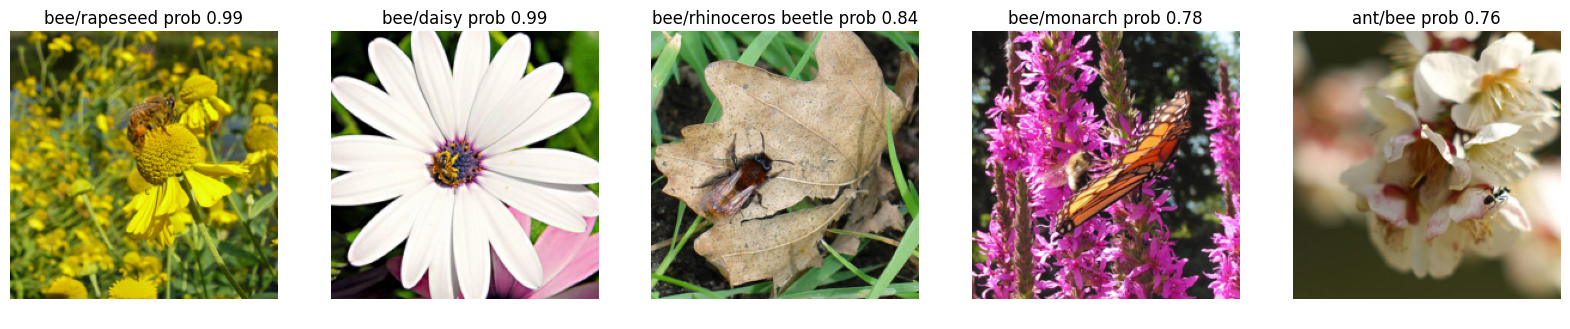

In [60]:
n_images= 5 
errors_df =errors_df[ ['image_index','probability','prediction','label']][0:n_images]
labels      = [  t.label for n, t in errors_df.iterrows() ]
predictions = [  t.prediction for n, t in errors_df.iterrows() ]
probs = [  t.probability for n, t in errors_df.iterrows() ]
tensors     = [  baseline_dataset[ t.image_index  ][0].reshape( 3,224,224) for n, t in errors_df.iterrows() ]

x = zip( labels, predictions, probs )
x = [ i[0]+'/'+i[1]+' prob ' + str(round(i[2],2)) for  i in x ]

stacked = torch.vstack( tensors ).reshape( n_images,3,224,224)
display_image_tensors( stacked, x   )



# Fine-tuning

## Simple

In [104]:
 
def fine_tune_model(model, train_data_loader, criterion, optimizer , num_epochs=2):
  
 

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
     
        train_running_loss  =0.0 
        for inputs, labels in train_data_loader:

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item()*inputs.size(0)


        print( 'loss ', train_running_loss )


In [111]:

model_conv = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)#'IMAGENET1K_V1')

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(512, 2) 

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.0001, momentum=0.1)

fine_tune_model(model_conv,  data_loaders['train'], criterion, optimizer_conv,num_epochs=5)



Epoch 0/4
loss  168.690715610981
Epoch 1/4
loss  167.62604427337646
Epoch 2/4


loss  172.792853474617
Epoch 3/4
loss  174.74456751346588
Epoch 4/4
loss  175.25506854057312


In [109]:

freeze_model( model_conv )
model_conv.eval() 

predictions, labels = [], []
for _inputs, _labels in data_loaders['val']:

    _outputs = model_conv(_inputs)
    _, _preds = torch.max(_outputs, 1)
    predictions = predictions + _preds.tolist() 
    labels = labels + _labels.tolist() 


df = pd.DataFrame( {'predictions':predictions, 'labels':labels }) 
df['error'] = (df['predictions'] != df['labels']).astype( int )

accuracy =  (df.shape[0] - df['error'].sum())/df.shape[0]


0.5424836601307189


In [110]:
print(accuracy)

0.5424836601307189


In [82]:


model_ft = models.resnet18(weights=ResNet18_Weights.DEFAULT)
optimizer = optim.SGD(model_ft.fc.parameters(), lr=0.01, momentum=0.9)
fine_tune_model( model = model_ft, train_data_loader = data_loaders['train'], optimizer = optimizer, num_epochs = 15 ) 


Epoch 0/14


loss 0.5157917737960815

Epoch 1/14
loss 0.5165520906448364

Epoch 2/14
loss 0.5296373963356018

Epoch 3/14
loss 0.5210931897163391

Epoch 4/14
loss 0.5511775612831116

Epoch 5/14
loss 0.551500141620636

Epoch 6/14
loss 0.49667221307754517

Epoch 7/14
loss 0.5364305973052979

Epoch 8/14
loss 0.49468833208084106

Epoch 9/14
loss 0.5589920282363892

Epoch 10/14
loss 0.5211359262466431

Epoch 11/14
loss 0.5264766812324524

Epoch 12/14
loss 0.5457074642181396

Epoch 13/14
loss 0.5137552618980408

Epoch 14/14
loss 0.5470161437988281



0.5228758169934641


0.49673202614379086


In [206]:
model_ft = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)#'IMAGENET1K_V1')
for param in model_ft.parameters(): 
    param.requires_grad = False

model_ft.fc = nn.Identity( )
#model_ft.fc = nn.Linear( in_features = 512, out_features = 2, dtype = torch.float32  )


In [207]:
train_data_loader = data_loaders['train'] 
inputs, labels = None, None 
for xinputs, xlabels in train_data_loader:

    print( xlabels.dtype )
    inputs, labels = xinputs, xlabels 
    break 

inputs.shape 

torch.int64


torch.Size([4, 3, 224, 224])

In [211]:
classifier = nn.Sequential(
          nn.Linear(in_features = 512, out_features = 1, bias= True, dtype=torch.float32)
          #nn.BatchNorm1d( 64, dtype=torch.float32 ),               
          #nn.ReLU(),

          #nn.Linear(in_features = 64, out_features = 8, bias= True, dtype=torch.float32),
          #nn.BatchNorm1d( 8, dtype=torch.float32 ),             
          #nn.ReLU(),

          #nn.Linear(in_features = 8, out_features = 1, bias= True, dtype=torch.float32),
          #nn.Sigmoid()
        )


model_ft.eval()
outputs= model_ft(  inputs  )
print( outputs, outputs.shape )

x =  classifier( outputs )
print( x, x.shape, x.dtype)
loss_fn = nn.CrossEntropyLoss()# .BCELoss() 
loss_fn( x, labels )


tensor([[1.1614e+00, 5.6500e-01, 7.4068e-01,  ..., 5.6209e-01, 1.7924e-01,
         8.7746e-02],
        [7.7024e-01, 1.9817e-01, 1.0120e-05,  ..., 1.1646e+00, 4.3355e-04,
         2.2316e-01],
        [7.9534e-01, 3.5778e-01, 2.7486e-01,  ..., 5.5487e-01, 8.6381e-01,
         8.8105e-01],
        [3.2790e-01, 7.6819e-02, 6.7866e-02,  ..., 9.4764e-01, 8.5895e-03,
         7.8045e-01]]) torch.Size([4, 512])
tensor([[-0.4775],
        [-0.4009],
        [-0.3003],
        [-1.0323]], grad_fn=<AddmmBackward0>) torch.Size([4, 1]) torch.float32


tensor(0., grad_fn=<NllLossBackward0>)

In [99]:


    
#classifier
optimizer = optim.SGD(model_ft.fc.parameters(), lr=0.1, momentum=0.9)
criterion =  nn.BCELoss()


train_data_loader = data_loaders['train']
for inputs, labels in train_data_loader:
    optimizer.zero_grad()

    outputs = model_ft(inputs)

    print( outputs.shape, labels.unsqueeze(-1).shape, labels, labels.dtype, outputs.dtype   )

    #loss = criterion(outputs, labels)
    #loss.backward()
    #optimizer.step()
    
    break 


torch.Size([4, 1]) torch.Size([4, 1]) tensor([1, 0, 1, 1]) torch.int64 torch.float32


In [78]:
train_data_loader = data_loaders['train']
for inputs, labels in train_data_loader:

    print( inputs.dtype )
    break 


torch.float32


In [199]:
m = nn.Sigmoid()
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 2, requires_grad=True, dtype=torch.float32)
target = torch.rand(3, 2, requires_grad=False)
output = loss(m(input), target)
output

tensor(0.8968, grad_fn=<DivBackward1>)

Epoch 0/0
torch.int64 torch.Size([4]) torch.float32 torch.Size([4, 2])
torch.int64 torch.Size([4]) torch.float32 torch.Size([4, 2])


torch.int64 torch.Size([4]) torch.float32 torch.Size([4, 2])
torch.int64 torch.Size([4]) torch.float32 torch.Size([4, 2])
torch.int64 torch.Size([4]) torch.float32 torch.Size([4, 2])
torch.int64 torch.Size([4]) torch.float32 torch.Size([4, 2])
torch.int64 torch.Size([4]) torch.float32 torch.Size([4, 2])
torch.int64 torch.Size([4]) torch.float32 torch.Size([4, 2])
torch.int64 torch.Size([4]) torch.float32 torch.Size([4, 2])
torch.int64 torch.Size([4]) torch.float32 torch.Size([4, 2])
torch.int64 torch.Size([4]) torch.float32 torch.Size([4, 2])
torch.int64 torch.Size([4]) torch.float32 torch.Size([4, 2])
torch.int64 torch.Size([4]) torch.float32 torch.Size([4, 2])
torch.int64 torch.Size([4]) torch.float32 torch.Size([4, 2])
torch.int64 torch.Size([4]) torch.float32 torch.Size([4, 2])
torch.int64 torch.Size([4]) torch.float32 torch.Size([4, 2])
torch.int64 torch.Size([4]) torch.float32 torch.Size([4, 2])
torch.int64 torch.Size([4]) torch.float32 torch.Size([4, 2])
torch.int64 torch.Size([

In [34]:
model_ft.eval()
probabilities = [] 
predictions = [] 
true_labels = [] 
indices = [] 


for b,c, sample_index in baseline_data_loader:
    
    out = model_ft( b )

    print( out )    
    break 

    
    #probs = torch.nn.functional.softmax( out, dim = 1 ).max( dim = 1 ).values.detach().numpy().tolist()
    #probabilities = probabilities + probs  
    #indices = indices + sample_index.detach().numpy().tolist()
    
    #_, imagenet_indices = torch.max( out, 1 )
    #imagenet_labels = [  classes[index] for index in imagenet_indices ] 
    #predictions = predictions + imagenet_labels 
    #true_labels = true_labels + ['ant' if x ==0 else 'bee' for x  in c.detach().numpy().tolist() ]
  


tensor([[-0.2162, -0.2259],
        [-0.1332, -0.0611],
        [-0.1432, -0.1001],
        [ 0.0315, -0.0161]], grad_fn=<AddmmBackward0>)


In [ ]:

  
#model_ft = models.resnet18(weights='IMAGENET1K_V1')
#num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
#model_ft.fc = nn.Linear(num_ftrs, 2)
#criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)train_model( model_ft )

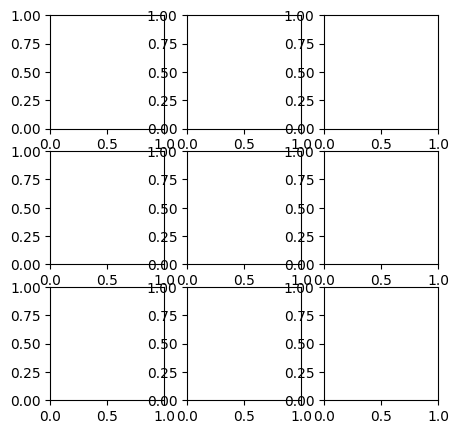

In [34]:


def get_grid(
    n:int, # Number of axes in the returned grid
    nrows:int=None, # Number of rows in the returned grid, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns in the returned grid, defaulting to `ceil(n/rows)` 
    figsize:tuple=None, # Width, height in inches of the returned figure
    title:str=None, # If passed, title set to the figure
    #return_fig:bool=False, # Whether to return the figure created by `subplots`
    **kwargs 
    ):
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows:
        ncols = ncols or int(np.ceil(n/nrows))
    elif ncols:
        nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n/nrows))
    
    fig,axs = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if title is not None: fig.suptitle(title, weight='bold', size=14)
    return (fig,axs) # if return_fig else axs

fig,ax =  get_grid( 9, figsize = (5,5) )

In [20]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 244
    Root location: data/hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )